In [1]:
from openai import OpenAI
import random
import json
import pandas as pd
import importlib

import constants # Required for the following line if kernel is restarted
importlib.reload(constants) # Else the old key value is retained
from constants import openai_api

client = OpenAI(api_key=openai_api)

In [2]:
from typing import List, Dict
import random
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class DummyQueryGenerator:
    def __init__(self):
        self.categories = pd.read_csv('data/google_trends.csv')
        self.categories['embedding'] = self.categories['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), dtype=float, sep=' '))
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')
        self.similarities = None
        
        self.style_prompt = ""

    def get_embedding(self, query: str):
        inputs = self.tokenizer(query, return_tensors='pt', truncation=True, padding=True)
        outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().tolist()


    # TODO: improve with more style features
    def analyze_query_style(self, query: str) -> Dict:
        style_features = {
            'length': len(query.split()),
            'has_question_mark': '?' in query,
            'starts_with_question_word': any(query.lower().startswith(w) for w in ['how', 'what', 'where', 'when', 'why', 'who']),
            'capitalization': query[0].isupper() if query else False,
            'lowercase_ratio': sum(1 for c in query if c.islower()) / len(query) if query else 0
        }
        return style_features

    # TODO: Identify within the embedding space
    def identify_query_category(self, query: str) -> str:
        # Get query embedding
        query_embedding = self.get_embedding(query)
        # Get most similar category with cosine similarity
        similarities = self.categories['embedding'].apply(lambda x: cosine_similarity(np.array(query_embedding).reshape(1, -1), x.reshape(1, -1))[0][0])
        self.similarities = similarities
        most_similar_category = self.categories.iloc[self.similarities.idxmax()]
        return most_similar_category['category']
        
        

    # TODO: Discuss, and implement/change as needed
    def get_distant_categories(self, num_categories: int = 20) -> List[str]:
        # Get all embeddings as numpy array
        embeddings = np.array(self.categories['embedding'].tolist())
        
        # 1. First divide the embedding space into regions using K-means
        from sklearn.cluster import KMeans
        n_clusters = min(num_categories, len(self.categories))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        
        # 2. Get cluster centers distances to query
        query_cluster_distances = kmeans.transform(embeddings[self.similarities.idxmax()].reshape(1, -1))[0]
        
        # 3. Sample categories from each cluster
        selected_categories = []
        cluster_assignments = {i: [] for i in range(n_clusters)}
        
        # Group categories by cluster
        for idx, cluster in enumerate(cluster_labels):
            cluster_assignments[cluster].append(idx)
        
        # Calculate samples per cluster to ensure uniform distribution
        samples_per_cluster = num_categories // n_clusters
        remaining_samples = num_categories % n_clusters
        
        # Sample from each cluster
        for cluster_idx in range(n_clusters):
            cluster_indices = cluster_assignments[cluster_idx]
            
            # Calculate number of samples for this cluster
            n_samples = samples_per_cluster + (1 if cluster_idx < remaining_samples else 0)
            
            if cluster_indices:  # If cluster is not empty
                # Random sampling within cluster
                sampled_indices = random.sample(cluster_indices, min(n_samples, len(cluster_indices)))
                selected_categories.extend(self.categories.iloc[sampled_indices]['category'].tolist())
        
        # Shuffle the final selection to avoid any patterns
        random.shuffle(selected_categories)
        
        return selected_categories
    
    def visualize_category_distribution(self, original_query: str, selected_categories: List[str]):
        # Get embeddings and categories
        selected_indices = self.categories[self.categories['category'].isin(selected_categories)].index
        all_embeddings = np.array(self.categories['embedding'].tolist())
        all_categories = self.categories['category'].tolist()
        
        # Get embedding for original query
        query_embedding = np.array(self.get_embedding(original_query)).reshape(1, -1)
        
        # Combine embeddings for TSNE
        combined_embeddings = np.vstack([all_embeddings, query_embedding])
        
        # Reduce dimensionality
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(combined_embeddings)
        
        # Separate categories and query coordinates
        categories_2d = embeddings_2d[:-1]
        query_2d = embeddings_2d[-1]
        
        # Create plot
        plt.figure(figsize=(15, 10))
        
        # Plot all categories
        plt.scatter(categories_2d[:, 0], categories_2d[:, 1], 
                alpha=0.1, color='gray', label='All Categories')
        
        # Plot selected categories with labels
        plt.scatter(categories_2d[selected_indices, 0], categories_2d[selected_indices, 1], 
                color='blue', alpha=0.6, label='Selected Categories')
        
        # Add labels for selected categories
        for idx in selected_indices:
            plt.annotate(all_categories[idx], 
                        (categories_2d[idx, 0], categories_2d[idx, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)
        
        # Plot and label original query
        plt.scatter(query_2d[0], query_2d[1], 
                color='red', s=200, marker='*', label='Original Query')
        plt.annotate('Original Query', 
                    (query_2d[0], query_2d[1]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=10, color='red', fontweight='bold')
        
        # Styling
        plt.legend(fontsize=10)
        plt.title('Distribution of Categories and Original Query in Embedding Space', 
                fontsize=12, pad=20)
        plt.grid(True, alpha=0.3)
        
        # Adjust layout to prevent label overlap
        plt.tight_layout()
        plt.show()


    def visualize_query_trajectories(self, original_query: str, dummy_queries: List[dict], follow_up_queries: List[dict]):
        """
        Visualize the distribution of categories, original query, dummy queries and their follow-ups
        """
        from sklearn.manifold import TSNE
        import matplotlib.pyplot as plt
        
        # Get all category embeddings
        all_embeddings = np.array(self.categories['embedding'].tolist())
        all_categories = self.categories['category'].tolist()
        
        # Get embeddings for original, dummy and follow-up queries
        original_embedding = np.array(self.get_embedding(original_query)).reshape(1, -1)
        dummy_embeddings = np.vstack([self.get_embedding(q['query']) for q in dummy_queries])
        followup_embeddings = np.vstack([self.get_embedding(q['query']) for q in follow_up_queries])
        
        # Combine all embeddings for TSNE
        combined_embeddings = np.vstack([
            all_embeddings,
            original_embedding,
            dummy_embeddings,
            followup_embeddings
        ])
        
        # Reduce dimensionality
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(combined_embeddings)
        
        # Separate different types of points
        categories_2d = embeddings_2d[:len(all_embeddings)]
        original_2d = embeddings_2d[len(all_embeddings)]
        dummy_2d = embeddings_2d[len(all_embeddings)+1:len(all_embeddings)+1+len(dummy_queries)]
        followup_2d = embeddings_2d[-len(follow_up_queries):]
        
        # Create plot
        plt.figure(figsize=(15, 10))
        
        # Plot categories in background
        plt.scatter(categories_2d[:, 0], categories_2d[:, 1], 
                alpha=0.1, color='gray', label='Categories')
        
        # Plot original query
        plt.scatter(original_2d[0], original_2d[1], 
                color='red', s=200, marker='*', label='Original Query')
        
        # Plot dummy and follow-up queries with arrows
        for i in range(len(dummy_queries)):
            # Plot dummy query point
            plt.scatter(dummy_2d[i, 0], dummy_2d[i, 1], 
                    color='blue', alpha=0.6, label='Dummy Query' if i == 0 else "")
            
            # Plot follow-up query point
            plt.scatter(followup_2d[i, 0], followup_2d[i, 1], 
                    color='green', alpha=0.6, label='Follow-up Query' if i == 0 else "")
            
            # Draw arrow from dummy to follow-up
            plt.arrow(dummy_2d[i, 0], dummy_2d[i, 1],
                    followup_2d[i, 0] - dummy_2d[i, 0],
                    followup_2d[i, 1] - dummy_2d[i, 1],
                    head_width=0.3, head_length=0.5, fc='k', ec='k', alpha=0.3)
            
            # Add labels
            plt.annotate(f"D{i+1}: {dummy_queries[i]['query'][:30]}...",
                        (dummy_2d[i, 0], dummy_2d[i, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)
            plt.annotate(f"F{i+1}: {follow_up_queries[i]['query'][:30]}...",
                        (followup_2d[i, 0], followup_2d[i, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)
        
        plt.title('Query Trajectory Visualization\nShowing Original Query, Dummy Queries, and Follow-ups',
                fontsize=12, pad=20)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


    def generate_dummy_queries(self, input_query: str, num_queries: int = 20):
        # Analyze input query style
        query_style = self.analyze_query_style(input_query)
        
        # Identify input category
        input_category = self.identify_query_category(input_query)
        
        # Get distant categories
        distant_categories = self.get_distant_categories(num_queries)  # Get enough categories for individual queries
        self.visualize_category_distribution(input_query, distant_categories)
        
        # Prepare style prompt
        style_prompt = f"""
        Generate a query that matches these style characteristics:
        - Similar length (around {query_style['length']} words)
        - {'Use' if query_style['has_question_mark'] else 'Avoid'} question marks
        - {'Start with question words' if query_style['starts_with_question_word'] else 'Use declarative form'}
        - {'Capitalize first letter' if query_style['capitalization'] else 'Use lowercase'}
        """

        all_queries = []
        print(distant_categories)
        # Generate one query per category
        for category in distant_categories:
            completion = client.chat.completions.create(
                model="gpt-4o-mini-2024-07-18",
                messages=[
                    {"role": "system", "content": f"""You are a query generation assistant. Generate a single query that:
                    1. Is completely unrelated to {input_category}
                    2. Is specifically about {category}
                    3. Matches the original query's style
                    {style_prompt}
                    Always respond with valid JSON containing a single query."""},
                    {"role": "user", "content": """Generate one search query.
                    Format your response as JSON with the following structure:
                    {
                        "queries": [
                            {"query": "query text", "category": "category_name"}
                        ]
                    }"""}
                ],
                response_format={ "type": "json_object" },
                temperature=0.7,
                seed=random.randint(0, 1000000)
            )
            
            # Parse and add the generated query
            query_result = parse_dummy_queries(completion.choices[0].message.content)
            all_queries.extend(query_result)
            
            # Break if we have enough queries
            if len(all_queries) >= num_queries:
                break

        return all_queries[:num_queries]
    
    
    # Consecutive query handling

    def generate_consecutive_queries(self,input_query, dummy_queries):        
        # Analyze input query style
        query_style = self.analyze_query_style(input_query)
        
        # Prepare style prompt
        style_prompt = f"""
        Generate a query that matches these style characteristics:
        - Similar length (around {query_style['length']} words)
        - {'Use' if query_style['has_question_mark'] else 'Avoid'} question marks
        - {'Start with question words' if query_style['starts_with_question_word'] else 'Use declarative form'}
        - {'Capitalize first letter' if query_style['capitalization'] else 'Use lowercase'}
        """
        all_queries = []
        for dummy_query in dummy_queries:
            # Generate a query that will act as a follow up to the dummy query
            follow_up_query = client.chat.completions.create(
                model="gpt-4o-mini-2024-07-18",
                messages=[{"role": "system", "content": f"""You are a query generation assistant. Generate a single query that:
                        1. Will act as a follow up to the query: {dummy_query['query']} 
                        2. Matches the following style characteristics:
                        {style_prompt}
                        Always respond with valid JSON containing a single query."""},
                        {"role": "user", "content": """Generate one search query.
                        Format your response as JSON with the following structure:
                        {
                            "queries": [
                                {"query": "query text"}
                            ]
                        }"""}],
                # TODO: No need for json object
                temperature=0.7,
                seed=random.randint(0, 1000000)
            )
            query_result = parse_dummy_queries(follow_up_query.choices[0].message.content)

            all_queries.extend(query_result)
                
        return all_queries
    
def parse_dummy_queries(response):
    return json.loads(response)['queries']


/home/ebk/anaconda3/envs/irs_proj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


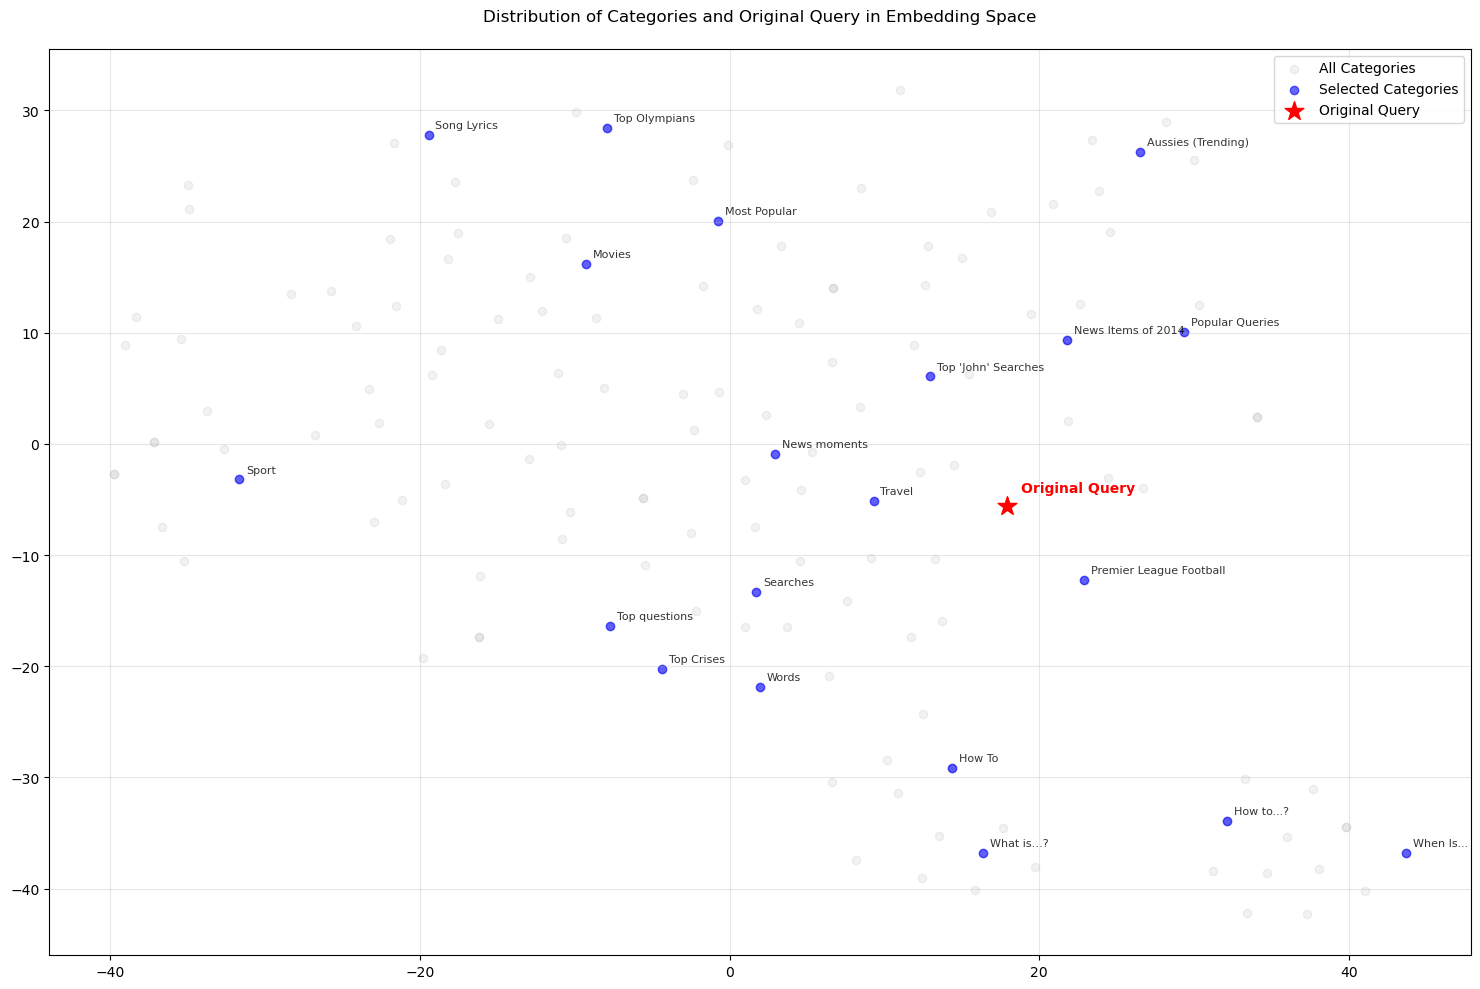

['Words', "Top 'John' Searches", 'Sport', 'Premier League Football', 'Most Popular', 'Movies', 'News moments', 'Song Lyrics', 'How To', 'Searches', 'What is…?', 'Aussies (Trending)', 'Top Crises', 'Popular Queries', 'News Items of 2014', 'Top questions', 'Top Olympians', 'Travel', 'When Is...', 'How to...?']
Initial dummy queries: 
{'query': 'word origins', 'category': 'linguistics'}
{'query': 'top john searches', 'category': 'trending'}
{'query': 'football statistics', 'category': 'Sport'}
{'query': 'premier league', 'category': 'football'}
{'query': 'most popular', 'category': 'trending topics'}
{'query': 'classic films', 'category': 'Movies'}
{'query': 'news highlights', 'category': 'News'}
{'query': 'song lyrics', 'category': 'music'}
{'query': 'how to meditate', 'category': 'self-improvement'}
{'query': 'search trends', 'category': 'searches'}
{'query': 'what is love', 'category': 'relationships'}
{'query': 'aussie trends', 'category': 'Aussies'}
{'query': 'top crises', 'category'

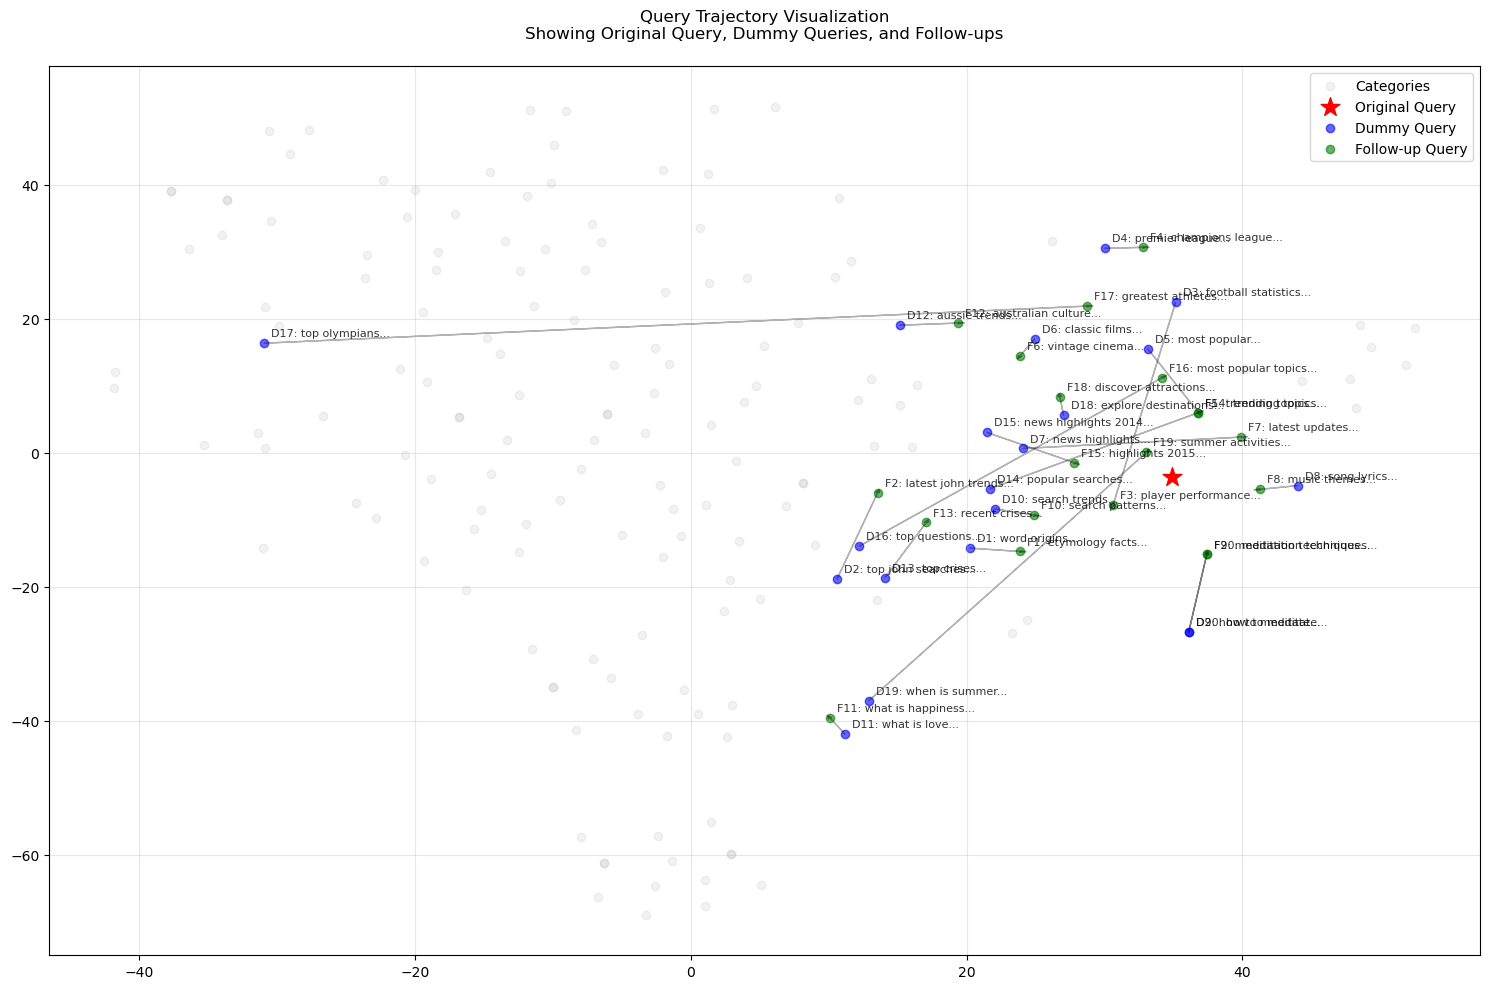

Consecutive queries 2: 
{'query': 'language origin details'}
{'query': 'recent john updates'}
{'query': 'player statistics overview'}
{'query': 'uefa finals history'}
{'query': 'latest news'}
{'query': 'classic film history'}
{'query': 'recent developments'}
{'query': 'music genre exploration'}
{'query': 'mindfulness practices'}
{'query': 'analyze trends'}
{'query': 'factors influencing happiness'}
{'query': 'australian traditions'}
{'query': 'global economic impact'}
{'query': 'latest news'}
{'query': 'memorable events 2015'}
{'query': 'top trending topics'}
{'query': 'legendary sports figures'}
{'query': 'explore local events'}
{'query': 'outdoor summer fun'}
{'query': 'mindfulness practices'}


In [3]:
# Usage
generator = DummyQueryGenerator()
dummy_queries = generator.generate_dummy_queries("cancer treatment")
print('Initial dummy queries: ')
for query in dummy_queries:
    print(query)

consecutive_queries = generator.generate_consecutive_queries("cancer symptoms", dummy_queries)
print('Consecutive queries: ')
for query in consecutive_queries:
    print(query)
    
generator.visualize_query_trajectories("cancer treatment", dummy_queries, consecutive_queries)

consecutive_queries_2 = generator.generate_consecutive_queries("chemotherapy side effects", consecutive_queries)
print('Consecutive queries 2: ')
for query in consecutive_queries_2:
    print(query)
    